## Chapter 3: a Tour of Machine Learning Classifiers ala Scikit-learn

### First steps with scikit-learn

#### Loading in Iris Dataset

We start by loading in the iris dataset, which is available via scikit-learn:

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()

# selecting out the 2nd and 3rd attributes, 'petal length' and 'petal width'
X = iris.data[:, [2, 3]]
y = iris.target

Note that we are workign with just 2 features so we can continue to visualize in 2-d and also that the target values are already in integer format; 0, 1, 2 correspond to Iris-Setosa, Iris-Versicolor, and Iris-Virginica.

In [2]:
np.unique(y)

array([0, 1, 2])

#### Splitting data set into training and test datasets

There will be more on this later in the book, but let's split up the dataset so we can cross validate.

In [3]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Let's also apply basic feature scaling 

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

And we can apply the built in version of the perceptron algorithm we authored in Chapter 2.

In [5]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.01, random_state=0)
ppn.fit(X_train_std, y_train)

y_pred = ppn.predict(X_test_std)

print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 4


In [6]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.91


It's interesting that when evaluating on unseen data we miss some points in the test set; in chapter 2 we were merely observing that we ultimately are able to fit all of the training data. Let's verify that the skikit-learn ppn also fully fits the training data: 

In [7]:
y_train_predict = ppn.predict(X_train_std)
print('Misclassified samples: %d' % (y_train != y_train_predict).sum())
print('Accuracy on training data: %.2f' % accuracy_score(
        y_train, 
        y_train_predict))

Misclassified samples: 10
Accuracy on training data: 0.90


Huh, I guess the scikit-learn perceptron is more careful not to overfit when training? Why else would it not have fit the training data 100%?

After reading ahead, it turns out we're looking at a larger sample of data that include 3 classes of flower and cannot be linearly separated. See below for the deets.

Now let's plot the decision regions. This version is improved from chapter 2

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
# %load decision_region_plot.py
"""
Helper function for plotting decision regions from Chapter 3 of Python Machine Learning.

It's improved on the Chapter 3 version in that it can plot the test vs training set differently.
"""

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
        X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
        warnings.warn('Please update to NumPy 1.9.0 or newer')
    else:
        X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                    alpha=1.0, linewidth=1, marker='o',
                    s=55, label='test set')


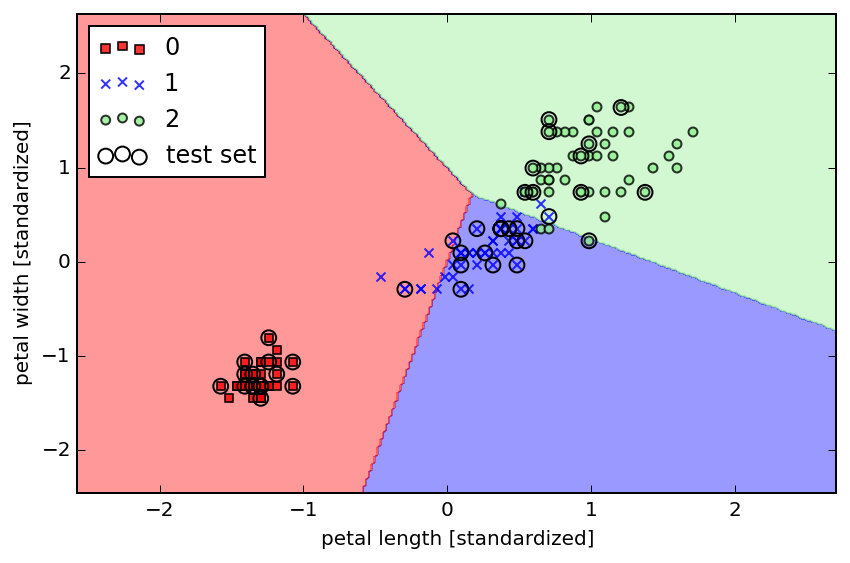

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, 
                      classifier=ppn, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/iris_perceptron_scikit.png', dpi=300)
plt.show()

## Logistic regression

Let's explore logistic regression, one of the most widely used linear classification algorithms and a more realistic choice than the perceptron.

See my [other notebook](http://karlrosaen.com/ml/notebooks/logistic-regression-why-sigmoid/) exploring some of the intuition behind why one would use a logistic function / sigmoid in the first place.

Let's see what a sigmoid function looks like, as it is what's used for the activation function in linear regresion.

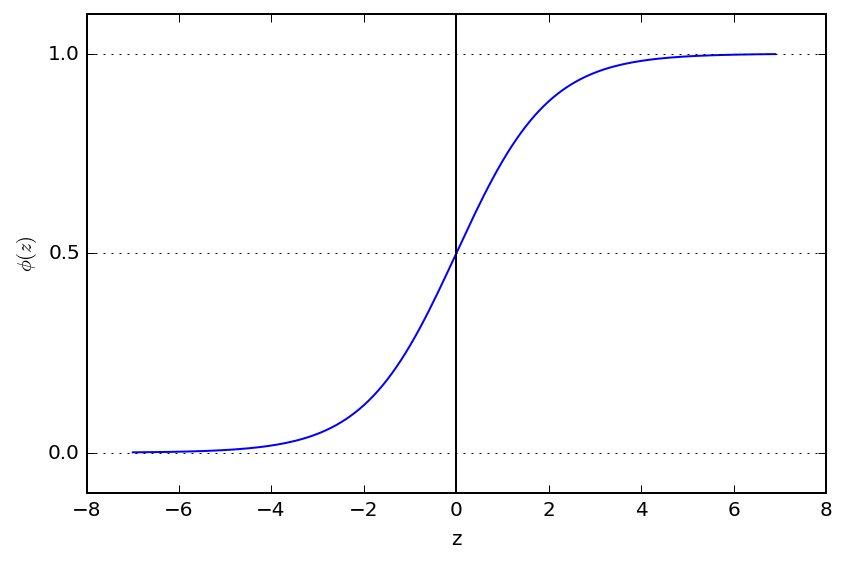

In [11]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

### Off the shelve Logistic Regression

Scikit-learn has a nicely optimized logistic regression classifier that supports multiclass settings, let's give it a whirl.

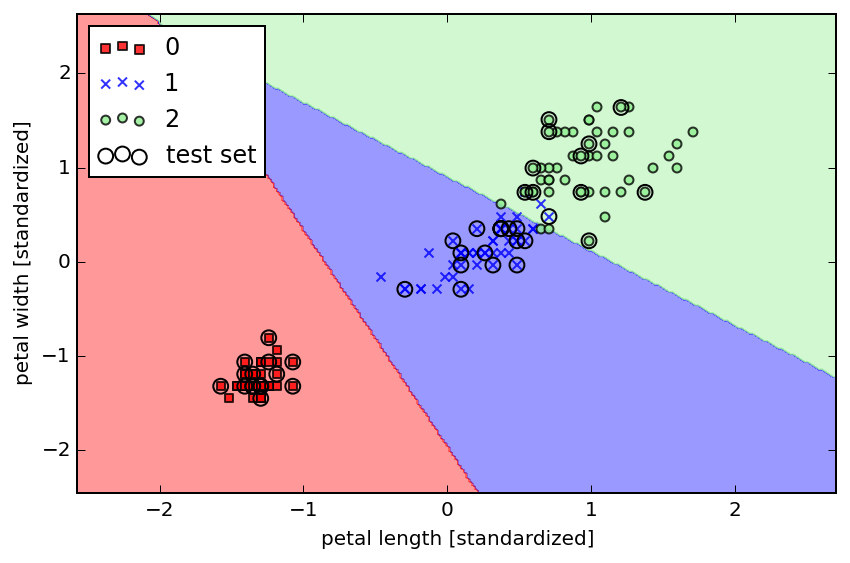

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/logistic_regression.png', dpi=300)
plt.show()

A handy feature is that we can get the class membership probability of an individual sample, something that wasn't available with our single-layer neural network classifiers from chapter 2:

In [13]:
["%.3f" % el for el in lr.predict_proba(X_test_std[0,:])[0]]

['0.000', '0.063', '0.937']

### Homegrown Logistic Regression implementation

The book notes

> If we were to implement logistic regression ourselves, we could simply substitute the cost function J in our Adaline implementation from Chapter 2

The author has published [a bonus notebook](http://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/bonus/logistic_regression.ipynb) doing just that. In chapter 2 I'd taken a slightly different approach to implementing Adeline, using a higher order function instead of a class. Here is my updated version:

In [14]:
# %load kr_decision_region_plot.py
"""
Helper function for plotting decision regions from Chapter 2 of Python Machine Learning.

Adapted to work with my different approach to implementation.
"""

from matplotlib.colors import ListedColormap


def kr_plot_decision_regions(plt, observations, labels, predict_fn, weights, resolution=0.02,
                          xlabel='sepal length [cm]', ylabel='petal length [cm]'):
    # we define a number of colors and markers and create a color map from
    # the list of colors via ListedColormap
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(labels))])

    # We determine the minimum and maximum values for the two features and use those
    # feature vectors to create a pair of grid arrays xx1 and xx2 via the NumPy meshgrid function
    x1_min, x1_max = observations[:, 0].min() - 1, observations[:, 0].max() + 1
    x2_min, x2_max = observations[:, 1].min() - 1, observations[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    # Since we trained our perceptron classifier on two feature dimensions,
    # we need to flatten the grid arrays and create a matrix that has the same number of
    # columns as the Iris training subset so that we can use the predict method to
    # predict the class labels Z of the corresponding grid points.
    Z = predict_fn(np.array([xx1.ravel(), xx2.ravel()]).T, weights)
    Z = Z.reshape(xx1.shape)

    # After reshaping the predicted class labels Z into a grid with the same dimensions
    # as xx1 and xx2, we can now draw a contour plot via matplotlib's contourf function
    # that maps the different decision regions to different colors for each
    # predicted class in the grid array
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(labels)):
        plt.scatter(x=observations[labels == cl, 0], y=observations[labels == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


In [31]:
# %load homegrown_lr.py
"""
Implementation of logistic regression for chapter 3 of "Python Machine Learning".
This is adapted from chapter 2's implementation of ADAptive LInear NEuron (Adaline).
"""
import numpy as np


def homegrown_lr(observations, labels, learning_rate=0.02, max_training_iterations=100):
    """
    Trains a (binary) perceptron, returning a function that can predict / classify
    given a new observations, as well as insight into how the training progressed via
    a log of the weights and squared errors for each iteration.

    :param observations: array of rows
    :param labels: correct label classification for each row: [1, -1, 1, 1, ...]
    :param learning_rate: how fast to update weights
    :param max_training_iterations: max number of times to iterate through observations
    :return: (prediction_fn, weights_log, errors_log)
    """
    the_weights = np.zeros(1 + observations.shape[1])
    weights_log = []
    num_errors_log = []
    squared_error_log = []

    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    def net_input(observations, weights):
        return np.dot(observations, weights[1:]) + weights[0]
    
    def activation(observations, weights):
        return sigmoid(net_input(observations, weights))

    def quantized_output(output):
        return np.where(output >= 0.5, 1, 0)

    def predict(observations, weights=the_weights):
        return quantized_output(activation(observations, weights))

    for _ in range(max_training_iterations):
        weights_log.append(np.copy(the_weights))
        raw_outputs = activation(observations, the_weights)
        errors = labels - raw_outputs
        weight_deltas = learning_rate * np.dot(observations.transpose(), errors)
        the_weights[1:] += weight_deltas
        the_weights[0] += learning_rate * np.sum(errors)

        squared_errors = (errors ** 2).sum() / 2.0
        num_errors = (quantized_output(raw_outputs) != labels).sum()
        squared_error_log.append(squared_errors)
        num_errors_log.append(num_errors)
        if num_errors == 0:
            break

    return predict, weights_log, squared_error_log, num_errors_log


And here is an application of it applied to a subset of the Iris dataset that only has two classes (my implementation has not been adapted to perform one-vs-rest to extend to multiple classes, so as in chapter 2, we only look at a binary example).

In [16]:
import pandas as pd

df = pd.read_csv('iris.data', header=None)

df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


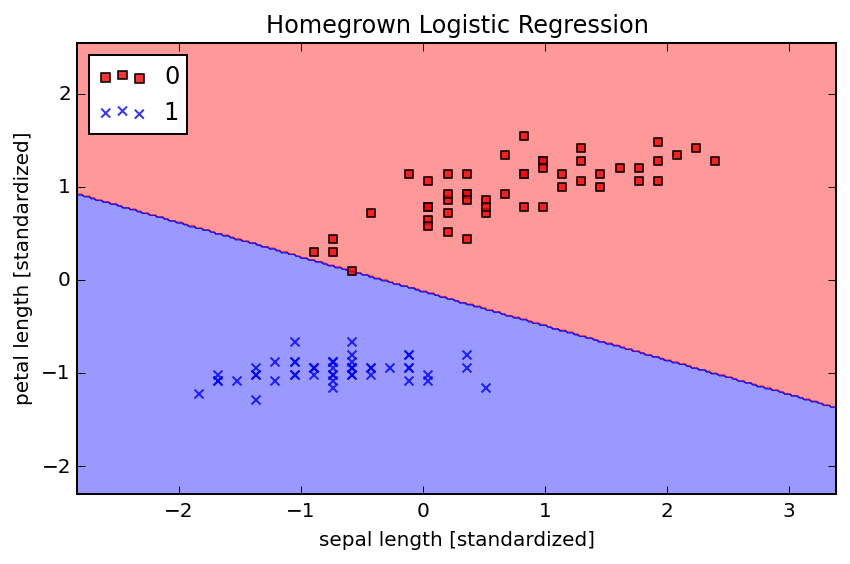

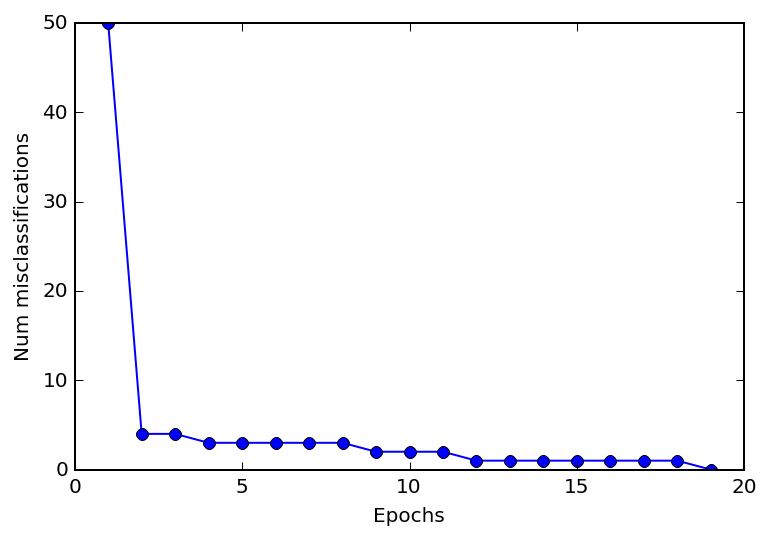

In [33]:
# Get the first 100 rows, selecting columns 0 and 2 (sepal and petal length)
sepal_petal_rows = df.iloc[0:100, [0, 2]].values

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 1, 0)

# standardize 
sepal_petal_rows_std = np.copy(sepal_petal_rows)
for i in range(sepal_petal_rows_std.shape[1]):
    sepal_petal_rows_std[:, i] = (sepal_petal_rows[:,i] - sepal_petal_rows[:,i].mean()) / sepal_petal_rows[:,i].std()

predict_lr_fn, weights_log, squared_error_log, num_errors_log = homegrown_lr(sepal_petal_rows_std, y, learning_rate=0.02)
plt.title('Homegrown Logistic Regression')
kr_plot_decision_regions(
    plt, sepal_petal_rows_std, y, predict_lr_fn, weights_log[-1],
    xlabel = 'sepal length [standardized]',
    ylabel = 'petal length [standardized]')

plt.plot(range(1, len(num_errors_log) + 1), num_errors_log, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Num misclassifications')
plt.show()